<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get processed data

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")


! cp -r gdrive/My\ Drive/5230Project/processed_data ./

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (118/118), 69.02 KiB | 1.64 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
! pip install muda

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, mir_eval, IPython.display, urllib


In [6]:
block_size = 5
path_workingFolder = '/content/processed_data/dataset_BeeNoBee_'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'
sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_random_0.json') 

In [21]:
def modify_labels():
    csv_file = path_workingFolder+"labels_BeeNotBee_th0.csv"
    labels_BeeNotBee_th0 = pd.read_csv(csv_file)

    def add_new_labels(df):
        labels_l=[]
        for x in df['label_strength']:
            if x>0.95:
                labels_l.append('nobee') 
            elif x==0:
                labels_l.append('bee') 
            else:
                labels_l.append('unknown') 
        df['label']=labels_l
        return df,labels_l,df['sample_name']
    
    labels_BeeNotBee_th0,labels,ids=add_new_labels(labels_BeeNotBee_th0)
    labels_BeeNotBee_th0.to_csv(csv_file)
    return labels,ids
labels,ids=modify_labels()

In [25]:
sample_ids=[]
for id in ids:
  sample_ids.append(id+'.wav')

In [26]:
X = get_features_from_samples(path_workingFolder, sample_ids, 'MFCCs20', 'NO', 1)
# X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
# X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)
    

In [27]:
Y=labels

In [15]:
# add normalizat - min_max
X_train_norm = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'min_max', 1)

In [9]:
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
Y_train= labels2binary('nobee', labels_train)
    
labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
Y_val= labels2binary('nobee', labels_val)
    
labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
Y_test= labels2binary('nobee', labels_test)

## pca

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
Y

In [59]:
pca = PCA(n_components = 2)

pca = PCA(n_components = 2).fit_transform(X)

pca_df = pd.DataFrame(data = pca, columns = ['component1', 'component2'])

pca_df = pd.concat([pca_df, pd.DataFrame(Y, columns = ['label'])], axis = 1)

Text(0.5, 1.0, 'True label')

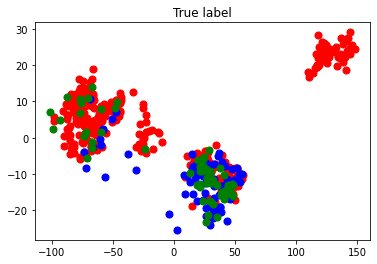

In [61]:
plt.scatter(pca_df[pca_df['label']=='bee'].iloc[:,0], pca_df[pca_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='nobee'].iloc[:,0], pca_df[pca_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='unknown'].iloc[:,0], pca_df[pca_df['label']=='unknown'].iloc[:,1], c='g', s=50, cmap='viridis')

plt.title("True label")

Text(0.5, 1.0, 'True label')

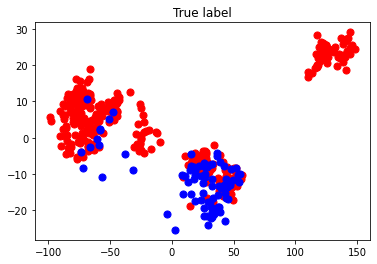

In [62]:
plt.scatter(pca_df[pca_df['label']=='bee'].iloc[:,0], pca_df[pca_df['label']=='bee'].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pca_df[pca_df['label']=='nobee'].iloc[:,0], pca_df[pca_df['label']=='nobee'].iloc[:,1], c='b', s=50, cmap='viridis')

plt.title("True label")

In [66]:
pca = PCA(n_components = 3)

pca = PCA(n_components = 3).fit_transform(X)

pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2','PC3'])

pca_df1 = pd.concat([pca_df, pd.DataFrame(Y, columns = ['label'])], axis = 1)

In [67]:
import plotly.express as px
fig = px.scatter_3d(pca_df1, x='PC1', y='PC2', z='PC3',color='label')
fig.show()

## K-means

In [20]:
model = sklearn.cluster.KMeans(n_clusters=2)
labels_pca = model.fit_predict(pca)
labels_pca

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [50]:
model = sklearn.cluster.KMeans(n_clusters=3)
labels = model.fit_predict(X)
labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
labels_norm = model.fit_predict(X_train_norm)
labels_norm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [24]:
pred_km = pd.concat([pca_df, pd.DataFrame(list(labels), columns = ['predicted_label'])],axis=1)

plot results 

Text(0.5, 1.0, 'prediction with K-means')

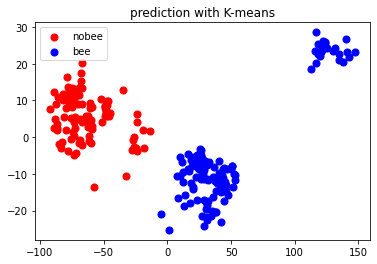

In [ ]:

plt.scatter(pred_km[pred_km['predicted_label']==0].iloc[:,0], pred_km[pred_km['predicted_label']==0].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pred_km[pred_km['predicted_label']==1].iloc[:,0], pred_km[pred_km['predicted_label']==1].iloc[:,1], c='b', s=50, cmap='viridis')

plt.legend(('nobee', 'bee'))
plt.title("prediction with K-means")

Text(0.5, 1.0, 'True label')

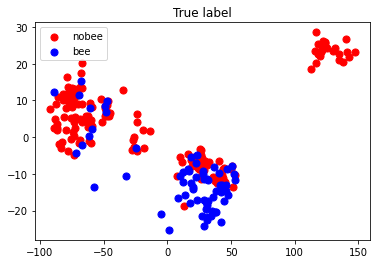

In [ ]:
plt.scatter(pred_km[pred_km['label']==0].iloc[:,0], pred_km[pred_km['label']==0].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pred_km[pred_km['label']==1].iloc[:,0], pred_km[pred_km['label']==1].iloc[:,1], c='b', s=50, cmap='viridis')

plt.legend(('nobee', 'bee'))
plt.title("True label")

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(list(labels), Y_train)
cm

array([[86, 14],
       [88, 53]])

In [39]:
from sklearn.metrics import f1_score
f1_score(labels, Y_train)

0.5096153846153847

In [40]:
from sklearn.metrics import average_precision_score
average_precision_score(labels, Y_train)

0.6624883000904369

In [30]:
accuracy_score(labels, Y_train)

0.5767634854771784

In [33]:
accuracy_score(labels_pca, Y_train)

0.5975103734439834

In [38]:
for i in range(1,80):
  print(i)
  pca_80 = PCA(n_components = i).fit_transform(X_train)
  labels_80 = model.fit_predict(pca_80)
  print(accuracy_score(labels_80, Y_train))

[2020-08-10 21:00:55 RAM6.7% 0.23GB] 1
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 2
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 3
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 4
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 5
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 6
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 7
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:55 RAM6.7% 0.23GB] 8
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 9
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 0.4024896265560166
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 10
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 0.5975103734439834
[2020-08-10 21:00:56 RAM6.7% 0.23GB] 11
[2020-08-

In [31]:
#testing dataset
y_test = model.fit_predict(X_test)
accuracy_score(y_test, Y_test)

0.5925925925925926